In [1]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

seed = MasterRNG(42)

In [2]:
m = 100 # Number of points
n = 110 # Number of curves
x = np.linspace(0, 1, m)

def one_function(x):
    model = Gaussian(dim=1, var=3, len_scale=0.3)
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0]=0
    for i in range(1,len(f)):
        result[i] = integrate.simps(f[:i+1], x[:i+1])
    return result

# Generate data
U = np.zeros((m,n))    
for i in range(m):
    U[:,i] = one_function(x)
    
S = np.zeros((m,n))
for i in range(n):
    S[:,i] = integrate_one_function(U[:,i])

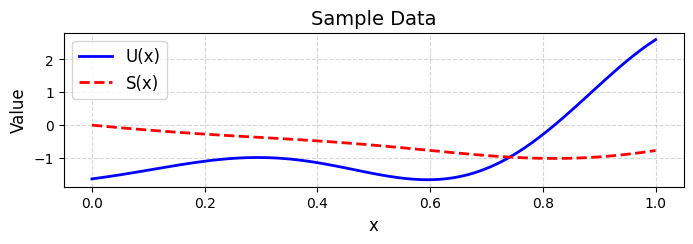

In [3]:
# Plot sample data
plt.figure(figsize=(8, 2))
plt.plot(x, U[:, 50:51], label='U(x)', color='blue', linestyle='-', linewidth=2)
plt.plot(x, S[:, 50:51], label='S(x)', color='red', linestyle='--', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Sample Data', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [4]:
# us -> m x n = 11000 ==> us (11000, 100)
# xs -> (11000, 1)
# ss -> (11000, 1)

def iterate_data(m=m, n=n, x=x, U=U, S=S):
    us = np.zeros((m*n, m))
    xs = np.zeros((m*n, 1))
    ss= np.zeros((m*n, 1))
    for i in range(n):
        for j in range(m):
            us[i*m+j, :] = U[:, i]
            xs[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, xs, ss

us, xs, ss = iterate_data()  
print(us.shape, xs.shape, ss.shape)

(11000, 100) (11000, 1) (11000, 1)


In [5]:
def batch_dataset(batch_size, m=m, n=n, x=x, U=U, S=S, ratio=0.9):
    us, xs, ss = iterate_data(m=m, n=n, x=x, U=U, S=S)
    
    train_size = int(len(us)*ratio)
    us_train = us[:train_size]
    xs_train = xs[:train_size]
    ss_train = ss[:train_size]
    
    us_test = us[train_size:]
    xs_test = xs[train_size:]
    ss_test = ss[train_size:]
    
    us_train = torch.tensor(us_train, dtype=torch.float32)
    xs_train = torch.tensor(xs_train, dtype=torch.float32)
    ss_train = torch.tensor(ss_train, dtype=torch.float32)
    
    us_test = torch.tensor(us_test, dtype=torch.float32)
    xs_test = torch.tensor(xs_test, dtype=torch.float32)
    ss_test = torch.tensor(ss_test, dtype=torch.float32)
    
    train_dataset = torch.utils.data.TensorDataset(us_train, xs_train, ss_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    test_dataset = torch.utils.data.TensorDataset(us_test, xs_test, ss_test)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = batch_dataset(batch_size=8192, ratio=0.9) 

# Check the shape of the data 
for u_batch, x_batch, s_batch in train_dataloader:
    print(u_batch.shape, x_batch.shape, s_batch.shape)
    break

torch.Size([8192, 100]) torch.Size([8192, 1]) torch.Size([8192, 1])


In [6]:
class DeepONet(nn.Module):
    def __init__(self, neurons=40, in1=1, in2=1, output_neurons=20):
        super(DeepONet, self).__init__()
        self.in1 = in1
        self.in2 = in2
        self.neurons = neurons
        self.output_neurons = output_neurons
        
        self.branch = self.branch_network()
        self.trunk = self.trunk_network()
        
    def branch_network(self):
        branch = nn.Sequential(
            nn.Linear(self.in1, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return branch
            
    def trunk_network(self):
        trunk = nn.Sequential(
            nn.Linear(self.in2, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.neurons),
            nn.ReLU(),
            nn.Linear(self.neurons, self.output_neurons)
        )
        return trunk
    
    def forward(self, x1, x2):
        x1 = self.branch(x1)
        x2 = self.trunk(x2)
        x = torch.einsum("bi, bi->b", x1, x2)
        x = torch.unsqueeze(x, 1)
        return x

In [7]:
model = DeepONet(neurons=40, in1=m, in2=1, output_neurons=20)
model

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=20, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): ReLU()
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): ReLU()
    (6): Linear(in_features=40, out_features=20, bias=True)
  )
)

In [8]:
def loss(y_pred, y_true):
    return torch.mean((y_pred-y_true)**2)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
train_losses = []
epochs = 1000

for i in range(epochs):
    l_total = 0
    for u_batch, x_batch, s_batch in train_dataloader:
        model.train()
        optimizer.zero_grad()
        y_pred = model(u_batch, x_batch)
        
        l = loss(y_pred, s_batch)   
        l_total += l.item()
        l.backward()    
        optimizer.step()
        
    l_total = l_total/len(train_dataloader)
    train_losses.append(l_total)
    
    if i % 10 == 0:
        print(f'Epoch {i}/{epochs}, Loss: {l_total}')  

Epoch 0/1000, Loss: 0.6342287361621857
Epoch 10/1000, Loss: 0.13518857210874557
Epoch 20/1000, Loss: 0.04681626334786415
Epoch 30/1000, Loss: 0.028675501234829426
Epoch 40/1000, Loss: 0.021422630175948143
Epoch 50/1000, Loss: 0.01777526643127203
Epoch 60/1000, Loss: 0.015070807188749313
Epoch 70/1000, Loss: 0.01049014599993825
Epoch 80/1000, Loss: 0.007083697011694312
Epoch 90/1000, Loss: 0.00583647470921278
Epoch 100/1000, Loss: 0.005487518617883325
Epoch 110/1000, Loss: 0.004932750482112169
Epoch 120/1000, Loss: 0.004630090668797493
Epoch 130/1000, Loss: 0.004229401703923941
Epoch 140/1000, Loss: 0.0035862509394064546
Epoch 150/1000, Loss: 0.0029128467431291938
Epoch 160/1000, Loss: 0.0021848641335964203
Epoch 170/1000, Loss: 0.0018438078695908189
Epoch 180/1000, Loss: 0.0015474965330213308
Epoch 190/1000, Loss: 0.0013925936073064804
Epoch 200/1000, Loss: 0.0013016489101573825
Epoch 210/1000, Loss: 0.0012472247472032905
Epoch 220/1000, Loss: 0.0011702454648911953
Epoch 230/1000, Loss

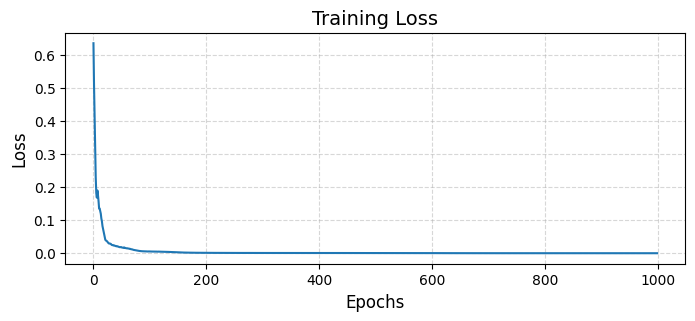

In [14]:
plt.figure(figsize=(8, 3))   
plt.plot(train_losses)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [15]:
my_func = lambda x: np.cos(x) * np.sin(x)
inter = lambda x: 1/2 * (np.sin(x))**2
u_t = my_func(x)
s_t = inter(x)

# Evaluate model
u_t_tens = torch.tensor(u_t, dtype=torch.float32).unsqueeze(0)
x_tens = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
print(u_t_tens.shape, x_tens.shape)

model.eval()
p = model(u_t_tens, x_tens)
p = p.detach().numpy()
print(p.shape)

torch.Size([1, 100]) torch.Size([100, 1])
(100, 1)


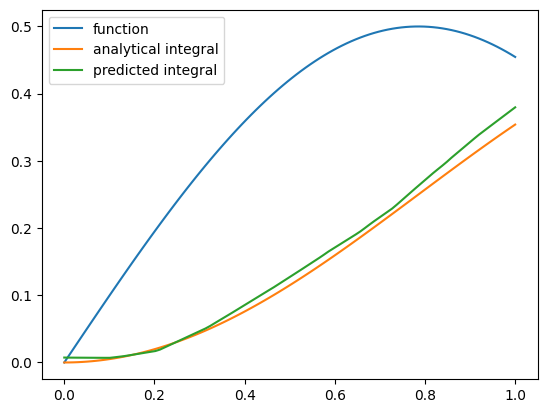

In [16]:
plt.plot(x, u_t, label='function')
plt.plot(x, s_t, label='analytical integral')
plt.plot(x, p, label='predicted integral')
plt.legend()
plt.show()